In [2]:

import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl

# glauber local ei

In [3]:
def trans10_to_base(number, base = 2, min_length=0):
    
    if min_length < 1:
        raise ValueError("Minimum length must be at least 1")
    
    if number == 0:
        return '0' * min_length

    digits = []
    while number > 0:
        digits.insert(0, str(number % base))
        number //= base

    # 将数字列表转换为字符串，并在前面填充字符以达到最小长度
    padded_digits = ''.join(digits).zfill(min_length)

    return padded_digits

def pro_str(s):
    return int(s) * 2 - 1

def ising_flip(H,T):
    return 1 / (1 + np.exp(H / T))
    
def ising_tpm(T):
    pur_tpm = np.zeros([32,2])
    for i in range(32):
        strs = trans10_to_base(i, min_length=5)
        H = 0
        for j in range(4):
            H += 2 * pro_str(strs[-1]) * pro_str(strs[j])
            
        p = ising_flip(H, T)
        
        if strs[-1] == '0':
            pur_tpm[i, 0] = 1 - p
            pur_tpm[i, 1] = p
        else:
            pur_tpm[i, 0] = p
            pur_tpm[i, 1] = 1 - p
            
    return pur_tpm

ising_tpm(2.2)

array([[0.97432841, 0.02567159],
       [0.97432841, 0.02567159],
       [0.86034782, 0.13965218],
       [0.86034782, 0.13965218],
       [0.86034782, 0.13965218],
       [0.86034782, 0.13965218],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.86034782, 0.13965218],
       [0.86034782, 0.13965218],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.13965218, 0.86034782],
       [0.13965218, 0.86034782],
       [0.86034782, 0.13965218],
       [0.86034782, 0.13965218],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.13965218, 0.86034782],
       [0.13965218, 0.86034782],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.13965218, 0.86034782],
       [0.13965218, 0.86034782],
       [0.13965218, 0.86034782],
       [0.13965218, 0.86034782],
       [0.

In [4]:
def tpm_ei(tpm, log_base = 2):
    # marginal distribution of y given x ~ Unifrom Dist
    puy = tpm.sum(axis=0)
    n = tpm.shape[0]
    # replace 0 to a small positive number to avoid log error
    eps = 1E-10
    tpm_e = np.where(tpm==0, eps, tpm)
    puy_e = np.where(tpm==0, eps, puy)
    
    # calculate EI of specific x
    ei_x = (np.log2(n * tpm_e / puy_e) / np.log2(log_base)  * tpm).sum(axis=1)
    
    # calculate total EI
    ei_all = ei_x.mean()
    return ei_all

def local_ei_ising(e_list, markov_matrix):
    local_markov = np.zeros([2, 2])
    for num in range(2):
        binary_string = trans10_to_base(num,  min_length = 1)
        padded_binary_string = e_list + binary_string
        binary_array = [int(bit) for bit in padded_binary_string] 
        pattern = int(''.join(str(cell) for cell in binary_array), 2)
        local_markov[num, :] = markov_matrix[pattern, :]
    ei = tpm_ei(local_markov, log_base = 2)
    return ei, local_markov 

markov = ising_tpm(2.2)
local_ei_ising('0001', markov)

(-6.890152495355112e-17,
 array([[0.86034782, 0.13965218],
        [0.86034782, 0.13965218]]))

# mech_size=2

In [6]:
def ising_flip2(T):
    pur_tpm = np.zeros([2**8,2**2])
    m_idx = np.array([3, 4])
    e_idx = np.array([[0, 2, 4, 6],[1, 3, 5, 7]])
    for i in range(2**8):
        strs = trans10_to_base(i, min_length=8)
        p_list = []
        for k in range(2):
            m = m_idx[k]
            H = 0
            for j in e_idx[k]:
                H += 2 * pro_str(strs[m]) * pro_str(strs[j])

            p_list.append(ising_flip(H, T))

        pur_tpm[i,:] = cal_tpm(strs, m_idx, p_list)
            
    return pur_tpm

def cal_tpm(strs, m_idx, p_list):
    m_len = len(m_idx)
    tpm_row = []
    for i in range(2**m_len):
        strs1 = trans10_to_base(i, min_length=m_len)
        p = 1
        for k in range(m_len):
            if strs[m_idx[k]] == strs1[k]:
                p *= (1 - p_list[k])
            else:
                p *= p_list[k]
        tpm_row.append(p)
    return tpm_row

ising_flip2(2.2)

array([[9.49315858e-01, 2.50125560e-02, 2.50125560e-02, 6.59030346e-04],
       [8.38261323e-01, 1.36067090e-01, 2.20864933e-02, 3.58509309e-03],
       [8.38261323e-01, 2.20864933e-02, 1.36067090e-01, 3.58509309e-03],
       ...,
       [3.58509309e-03, 1.36067090e-01, 2.20864933e-02, 8.38261323e-01],
       [3.58509309e-03, 2.20864933e-02, 1.36067090e-01, 8.38261323e-01],
       [6.59030346e-04, 2.50125560e-02, 2.50125560e-02, 9.49315858e-01]])

In [22]:
def local_ei_ising2(e_list, markov_matrix):
    local_markov = np.zeros([2**2, 2**2])
    for num in range(2**2):
        binary_string = trans10_to_base(num,  min_length = 2)
        padded_binary_string = e_list.replace('xx', binary_string)
        binary_array = [int(bit) for bit in padded_binary_string] 
        pattern = int(''.join(str(cell) for cell in binary_array), 2)
        local_markov[num, :] = markov_matrix[pattern, :]
    ei = tpm_ei(local_markov, log_base = 2)
    return ei, local_markov 

markov = ising_flip2(2.2)
local_ei_ising2('001xx010', markov)

(0.14625615370465045,
 array([[0.48716421, 0.01283579, 0.48716421, 0.01283579],
        [0.13606709, 0.00358509, 0.83826132, 0.02208649],
        [0.43017391, 0.06982609, 0.43017391, 0.06982609],
        [0.12014945, 0.01950273, 0.74019837, 0.12014945]]))

In [11]:
def syn_un(markov_matrix, middle_size=2):
    state_size = 2**middle_size
    ei_all = 0
    mixed_markov = np.zeros([state_size, state_size])
    for en in range(2**6):
        en_str = trans10_to_base(en, min_length = 6)
        en_str = en_str[:3] + 'xx' + en_str[3:]
        ei0, local_markov = local_ei_ising2(en_str, markov_matrix)
        ei_all += ei0
        mixed_markov += local_markov
    un = tpm_ei(mixed_markov / 2**6)
    syn = ei_all / 2**6 - un
    return syn, un, syn+un
    
markov = ising_flip2(5)
syn_un(markov)

(0.0049806454026983735, 0.04595060530246944, 0.05093125070516781)

<ipython-input-3-e737e5ce1c50>:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(H / T))


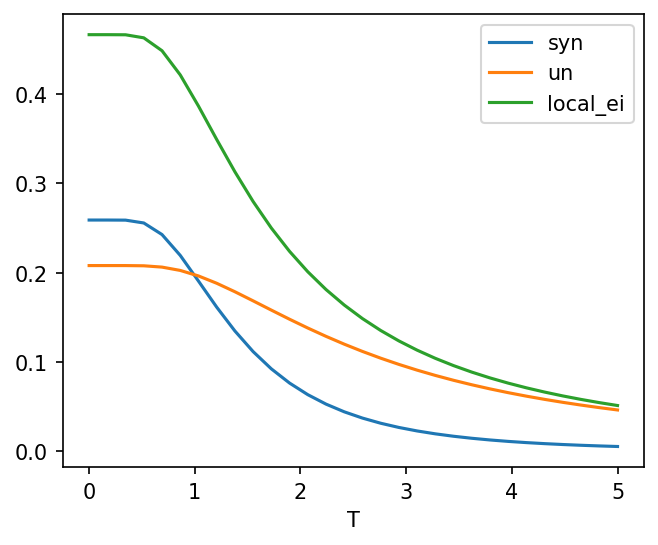

In [14]:
tem_list = np.linspace(0.001, 5, 30)
syn_list = []
un_list = []
ei_all_list = []
for T in tem_list:
    syn, un, ei_all = syn_un(ising_flip2(T))
    syn_list.append(syn)
    un_list.append(un)
    ei_all_list.append(ei_all)

plt.figure(figsize=(5,4), dpi=150)
plt.plot(tem_list, syn_list, label="syn")
plt.plot(tem_list, un_list, label="un")
plt.plot(tem_list, ei_all_list, label="local_ei")
plt.legend()
plt.xlabel('T')
plt.show()

# mech_size=4 square

In [20]:
def ising_flip4(T):
    pur_tpm = np.zeros([2**12,2**4])
    m_idx = np.array([3, 4, 7, 8])
    e_idx = np.array([[0, 2, 4, 7],[1, 3, 5, 8],[3, 6, 8, 10],[4, 7, 9, 11]])
    for i in range(2**12):
        strs = trans10_to_base(i, min_length=12)
        p_list = []
        for k in range(4):
            m = m_idx[k]
            H = 0
            for j in e_idx[k]:
                H += 2 * pro_str(strs[m]) * pro_str(strs[j])

            p_list.append(ising_flip(H, T))

        pur_tpm[i,:] = cal_tpm(strs, m_idx, p_list)
            
    return pur_tpm

def local_ei_ising4(e_list, markov_matrix):
    local_markov = np.zeros([2**4, 2**4])
    for num in range(2**4):
        binary_string = trans10_to_base(num,  min_length = 4)
        padded_binary_string = e_list[:3] + binary_string[:2] + e_list[3:5] + binary_string[2:] + e_list[5:]
        binary_array = [int(bit) for bit in padded_binary_string] 
        pattern = int(''.join(str(cell) for cell in binary_array), 2)
        local_markov[num, :] = markov_matrix[pattern, :]
    ei = tpm_ei(local_markov, log_base = 2)
    return ei, local_markov 

markov = ising_flip4(1.8)
local_ei_ising4('10101010', markov)

(0.6283659669930619,
 array([[2.44230024e-01, 2.86814666e-03, 2.44230024e-01, 2.86814666e-03,
         2.86814666e-03, 3.36824488e-05, 2.86814666e-03, 3.36824488e-05,
         2.44230024e-01, 2.86814666e-03, 2.44230024e-01, 2.86814666e-03,
         2.86814666e-03, 3.36824488e-05, 2.86814666e-03, 3.36824488e-05],
        [4.35946005e-02, 5.11958791e-04, 4.02282880e-01, 4.72426068e-03,
         4.72426068e-03, 5.54799621e-05, 4.35946005e-02, 5.11958791e-04,
         4.35946005e-02, 5.11958791e-04, 4.02282880e-01, 4.72426068e-03,
         4.72426068e-03, 5.54799621e-05, 4.35946005e-02, 5.11958791e-04],
        [4.35946005e-02, 4.72426068e-03, 4.35946005e-02, 4.72426068e-03,
         5.11958791e-04, 5.54799621e-05, 5.11958791e-04, 5.54799621e-05,
         4.02282880e-01, 4.35946005e-02, 4.02282880e-01, 4.35946005e-02,
         4.72426068e-03, 5.11958791e-04, 4.72426068e-03, 5.11958791e-04],
        [7.78155429e-03, 8.43271656e-04, 7.18067383e-02, 7.78155429e-03,
         8.43271656e-04, 9.

In [25]:
def syn_un4(markov_matrix, middle_size=4):
    state_size = 2**middle_size
    ei_all = 0
    mixed_markov = np.zeros([state_size, state_size])
    for en in range(2**8):
        en_str = trans10_to_base(en, min_length = 8)
        ei0, local_markov = local_ei_ising4(en_str, markov_matrix)
        ei_all += ei0
        mixed_markov += local_markov
    un = tpm_ei(mixed_markov / 2**8)
    syn = ei_all / 2**8 - un
    return syn, un, syn+un
    
markov = ising_flip4(5)
syn_un4(markov)

(0.012454592515037971, 0.18110022038896212, 0.1935548129040001)

<ipython-input-3-e737e5ce1c50>:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(H / T))


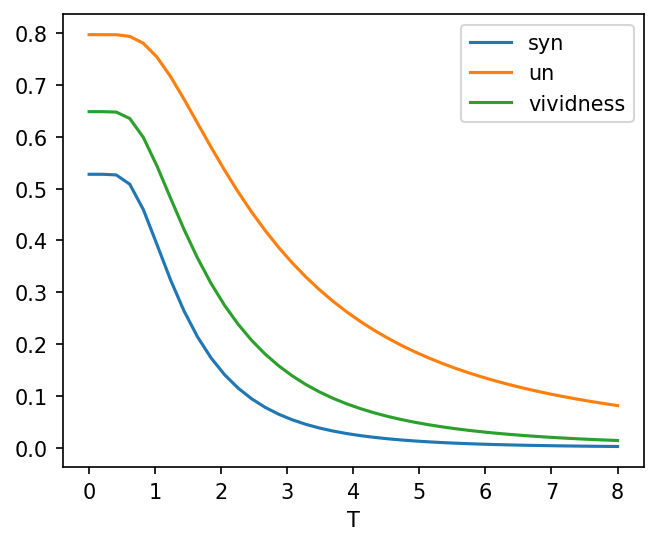

In [28]:
def live_comb(syn, un, alpha):
    return syn**alpha * un**(1 - alpha)

tem_list = np.linspace(0.001, 8, 40)
syn_list = []
un_list = []
ei_all_list = []
live_list = []
for T in tem_list:
    syn, un, ei_all = syn_un4(ising_flip4(T))
    syn_list.append(syn)
    un_list.append(un)
    ei_all_list.append(ei_all)
    live_list.append(live_comb(syn,un,0.5))

plt.figure(figsize=(5,4), dpi=150)
plt.plot(tem_list, syn_list, label="syn")
plt.plot(tem_list, un_list, label="un")
#plt.plot(tem_list, ei_all_list, label="local_ei")
plt.plot(tem_list, live_list, label="vividness")
plt.legend()
plt.xlabel('T')
plt.show()

<ipython-input-3-e737e5ce1c50>:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(H / T))


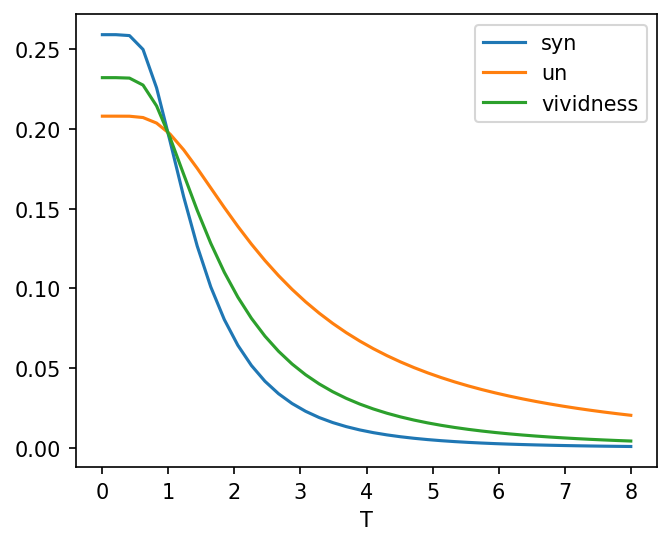

In [29]:
def live_comb(syn, un, alpha):
    return syn**alpha * un**(1 - alpha)

tem_list = np.linspace(0.001, 8, 40)
syn_list = []
un_list = []
ei_all_list = []
live_list = []
for T in tem_list:
    syn, un, ei_all = syn_un(ising_flip2(T))
    syn_list.append(syn)
    un_list.append(un)
    ei_all_list.append(ei_all)
    live_list.append(live_comb(syn,un,0.5))

plt.figure(figsize=(5,4), dpi=150)
plt.plot(tem_list, syn_list, label="syn")
plt.plot(tem_list, un_list, label="un")
#plt.plot(tem_list, ei_all_list, label="local_ei")
plt.plot(tem_list, live_list, label="vividness")
plt.legend()
plt.xlabel('T')
plt.show()